## Example XRD data analysis

In this notebook we'll demo an example analysis using background-subtracted XRD data. The analysis consists of splitting some background-subtracted XRD data into segments containing one or more peaks, and then fitting a model of some linear background and some pseudo-Voigt peaks to each segment found.

In [1]:
# An IPython Magic to automatically reload any of this notebook's dependencies
# when they're edited (preventing you from needing to reload the kernel)
%load_ext autoreload
%autoreload 3

In [2]:
# imports
import sys, pathlib, glob
import pandas as pd
import sqlalchemy as sqa

This notebook uses some pre-written analysis and plotting code stored in the "`src/xrd_analysis`" folder of the repository. Feel free to edit it if you'd like to make improvements.

In [3]:
# imports from the local code
repo_root_dir = pathlib.Path().resolve().parent

xrd_analysis_code_path = str(repo_root_dir / "src" / "xrd_analysis")
if xrd_analysis_code_path not in sys.path:
    sys.path.append(xrd_analysis_code_path)
from utils import get_raw_file_name
from analysis import get_peak_segments, get_segment_peak_fit
from plotting import (
    plot_peak_segments,
    plot_segment_peak_fit,
    plot_dataset_with_fitted_peaks,
)

### Read the background-subtracted XRD data into a Pandas DataFrame

In [4]:
xrd_data_dir = repo_root_dir.parent / "xrd_example_files"

xrd_data_file_paths = glob.glob(f"{xrd_data_dir}/*.csv")

In [5]:
# Use only the first file as an example to show off the method
test_file_index = 0
xrd_data_file = xrd_data_file_paths[test_file_index]

In [6]:
print(get_raw_file_name(xrd_data_file))

ML_Wallace_17122019_1_NN_1_ZrP_Crucible_12x16_14x161of2Crucibles_BlackPowder_5-60_4min_BkgSubtracted.raw



In [7]:
xrd_df = pd.read_csv(xrd_data_file, skiprows=2, names=["angle", "counts"])

### Find segments in the data containing one or more candidate peaks

In [8]:
peak_segments = get_peak_segments(xrd_df)

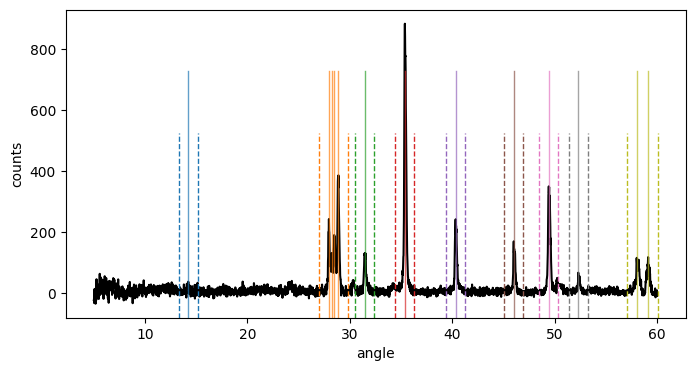

In [9]:
plot_peak_segments(xrd_df, peak_segments)

### Fit a background+peak(s) model to each segment independently

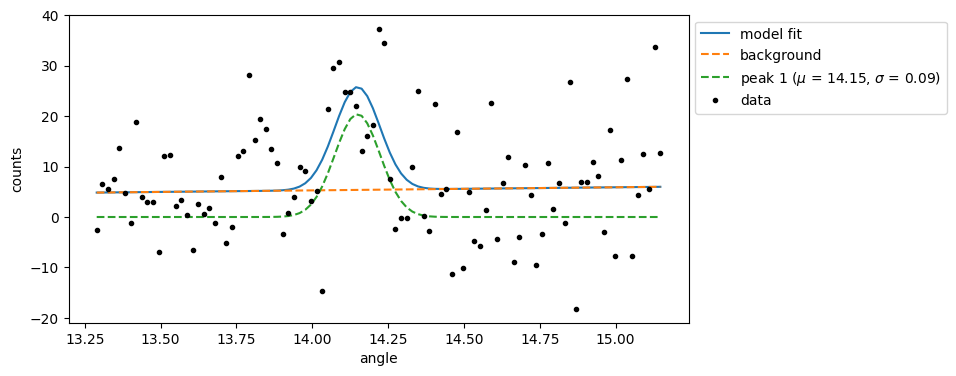

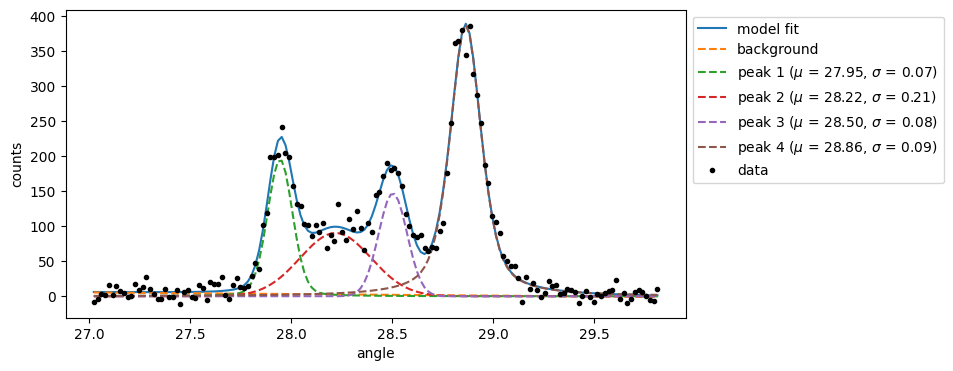

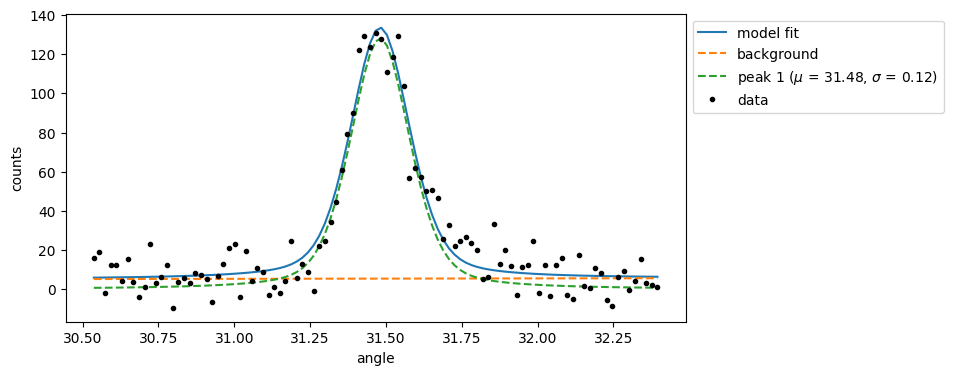

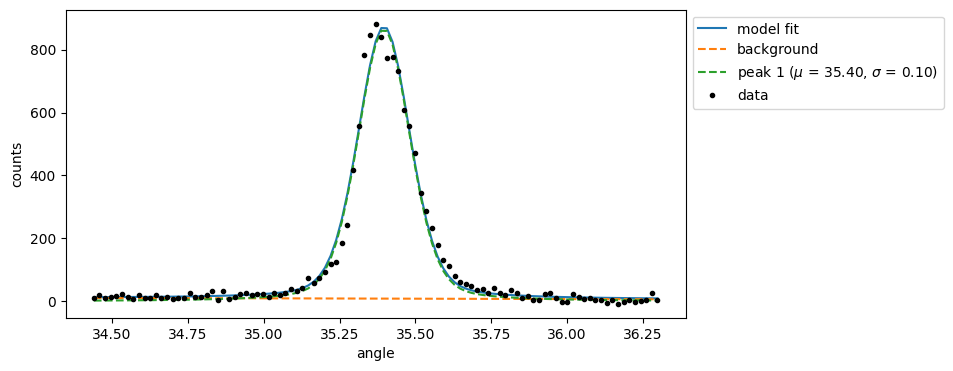

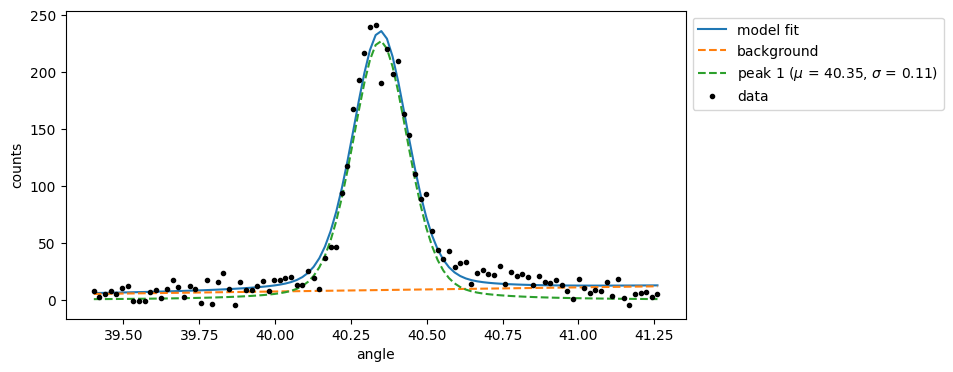

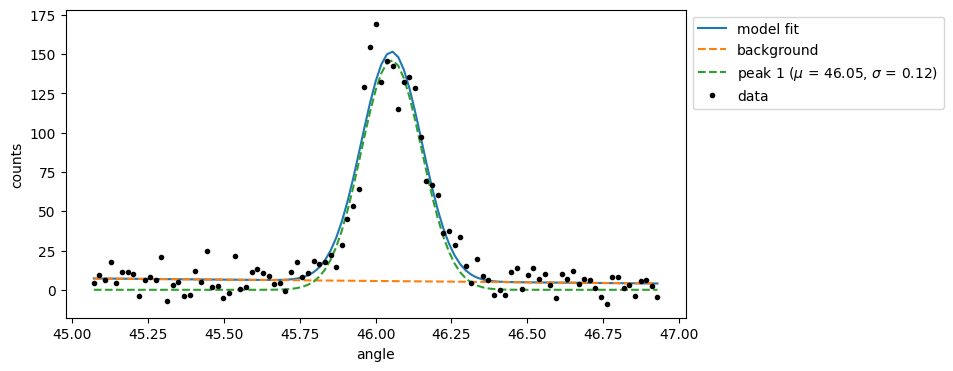

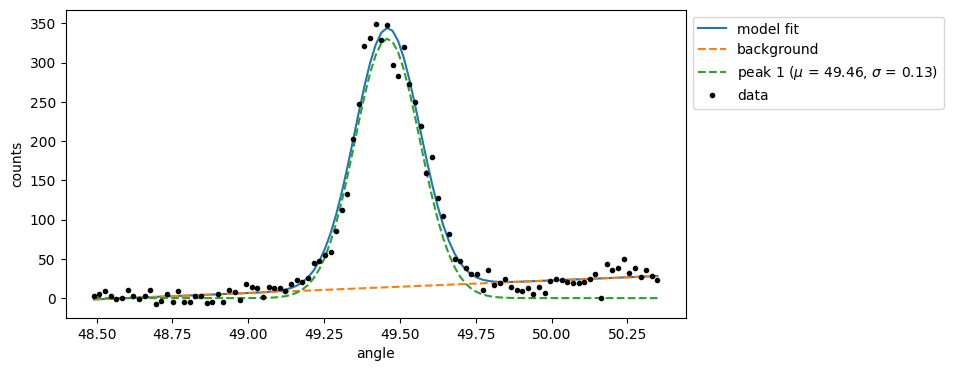

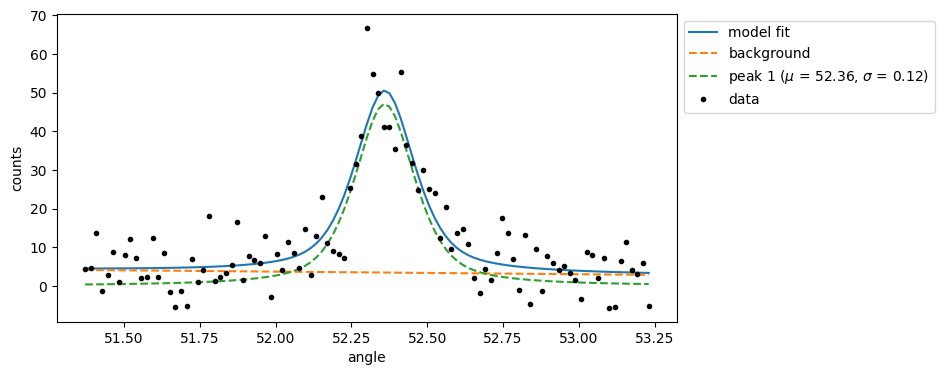

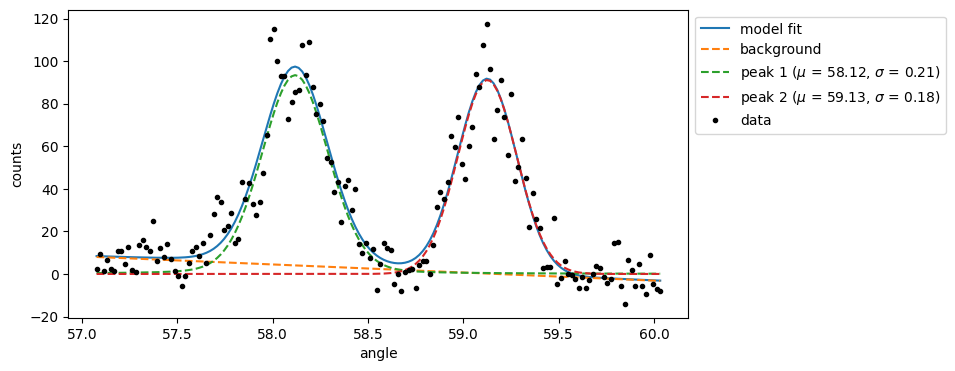

In [10]:
for i_seg, peak_seg in enumerate(peak_segments):
    # Pull out the part of the dataframe that's within the segment
    seg_df = xrd_df[
        ((xrd_df["angle"] >= peak_seg["min"]) & (xrd_df["angle"] <= peak_seg["max"]))
    ]
    fit_result = get_segment_peak_fit(xrd_df, peak_seg)
    # print(fit_result.fit_report())
    plot_segment_peak_fit(seg_df, fit_result)

### Run the analysis in a batched mode, adding results to a local sqlite database using SQLAlchemy

In [11]:
# import the ORM table classes
from sql_tables import (
    ORMBase,
    DataSet,
    DataPoint,
    DataSegment,
    CandidatePeak,
    SegmentFit,
    Background,
    FittedPeak,
)

In [12]:
# Define the path to the output db file
output_db_path = repo_root_dir.parent / "example_xrd_analysis_results.sqlite"

# Create a SQLAlchemy engine to interact with the DB
# You could edit this connection string to use a different DB
connection_string = f"sqlite:///{output_db_path.resolve().as_posix()}"
engine = sqa.create_engine(connection_string)

In [13]:
# Connect to the database and drop and recreate all of the expected tables
ORMBase.metadata.drop_all(bind=engine)
ORMBase.metadata.create_all(bind=engine)

In [14]:
# Create a session to interact with the DB using the ORM
Session = sqa.orm.sessionmaker(bind=engine)
session = Session()

In [15]:
# Iterate over all files and add entries for each to the DB
for xrd_data_file_path in xrd_data_dir.glob("*.csv"):
    # Add an entry for the dataset itself (one per file)
    dataset_entry = DataSet(
        file_name=xrd_data_file_path.name,
        raw_file_name=get_raw_file_name(xrd_data_file_path),
    )
    session.add(dataset_entry)
    session.commit()
    dataset_id = dataset_entry.ID
    # Read the file into a dataframe and add DataPoint entries for all of its points
    xrd_df = pd.read_csv(xrd_data_file_path, skiprows=2, names=["angle", "counts"])
    for index, row in xrd_df.iterrows():
        datapoint_entry = DataPoint(
            dataset_id=dataset_id, angle=row["angle"], counts=row["counts"]
        )
        session.add(datapoint_entry)
    session.commit()
    # Identify segments containing candidate peaks
    peak_segments = get_peak_segments(xrd_df)
    for peak_segment in peak_segments:
        # Add an entry for the segment
        segment_entry = DataSegment(
            dataset_id=dataset_id,
            min_angle=peak_segment["min"],
            max_angle=peak_segment["max"],
        )
        session.add(segment_entry)
        session.commit()
        segment_id = segment_entry.ID
        # And entries for the candidate peaks
        for cand_peak_angle in peak_segment["peak_angles"]:
            candidate_peak_entry = CandidatePeak(
                segment_id=segment_id, angle=cand_peak_angle
            )
            session.add(candidate_peak_entry)
        session.commit()
        # Perform the fit to the data segment and get the peak components of the model
        fit_result = get_segment_peak_fit(xrd_df, peak_segment)
        fit_summary = fit_result.summary()
        pseudo_voigt_components = []
        for component in fit_result.model.components:
            if component.prefix.startswith("voigt"):
                pseudo_voigt_components.append(component)
        # Add an entry for the result of the fit
        segment_fit_entry = SegmentFit(
            segment_id=segment_id,
            method=fit_summary["method"],
            ndata=fit_summary["ndata"],
            chisqr=fit_summary["chisqr"],
            redchi=fit_summary["redchi"],
            rsquared=fit_summary["rsquared"],
            nfev=fit_summary["nfev"],
            aborted=fit_summary["aborted"],
            success=fit_summary["success"],
            message=fit_summary["message"],
        )
        session.add(segment_fit_entry)
        # Add an entry for the background portion of the fit
        background_fit_entry = Background(
            segment_id = segment_id,
            init_slope = fit_summary["init_values"]["linear_slope"],
            init_intercept = fit_summary["init_values"]["linear_intercept"],
            fitted_slope = fit_summary["best_values"]["linear_slope"],
            fitted_intercept = fit_summary["best_values"]["linear_intercept"],
            slope_stderr = fit_result.params["linear_slope"].stderr,
            intercept_stderr = fit_result.params["linear_intercept"].stderr,
        )
        session.add(background_fit_entry)
        # Add entries for each peak found
        for peak_comp in pseudo_voigt_components:
            prefix = peak_comp.prefix
            peak_fit_entry = FittedPeak(
                segment_id = segment_id,
                init_amplitude = fit_summary["init_values"][f"{prefix}amplitude"],
                init_center = fit_summary["init_values"][f"{prefix}center"],
                init_sigma = fit_summary["init_values"][f"{prefix}sigma"],
                init_fraction = fit_summary["init_values"][f"{prefix}fraction"],
                fitted_amplitude = fit_summary["best_values"][f"{prefix}amplitude"],
                fitted_center = fit_summary["best_values"][f"{prefix}center"],
                fitted_sigma = fit_summary["best_values"][f"{prefix}sigma"],
                fitted_fwhm = 2.0*fit_summary["best_values"][f"{prefix}sigma"],
                fitted_fraction = fit_summary["best_values"][f"{prefix}fraction"],
                amplitude_stderr = fit_result.params[f"{prefix}amplitude"].stderr,
                center_stderr = fit_result.params[f"{prefix}center"].stderr,
                sigma_stderr = fit_result.params[f"{prefix}sigma"].stderr,
                fraction_stderr = fit_result.params[f"{prefix}fraction"].stderr,
            )
            session.add(peak_fit_entry)
        session.commit()
session.close()

### Some example queries using the DB we just created

In [16]:
# Create a new session for making queries
session = Session()

In [17]:
# Find all datasets with at least 3 peaks found with 2theta between 25 and 30 degrees
# (Characteristic of ZrP)
zrp_datasets = (
    session.query(DataSet)
    .join(DataSegment)
    .join(FittedPeak)
    .filter(FittedPeak.fitted_center.between(25,30))
    .group_by(DataSet.ID)
    .having(sqa.func.count(FittedPeak.ID)>=3)
    .all()
)

In [18]:
print("ZrP candidate XRD datasets:")
for dataset in zrp_datasets:
    print(f"{dataset.file_name} ({dataset.raw_file_name})")

ZrP candidate XRD datasets:
ZrP_1.csv (ML_Wallace_17122019_1_NN_1_ZrP_Crucible_12x16_14x161of2Crucibles_BlackPowder_5-60_4min_BkgSubtracted.raw
)
ZrP_2.csv (ML_Wallace_03012020_1_NN_1_ZrP_900CCrucible_5-60_4min_BkgSubtracted.raw_1
)
ZrP_3.csv (ML_Wallace_04122019_1_NN_1_ZrP_CrucibleRetest_5-60_4min_BkgSubtracted.raw
)


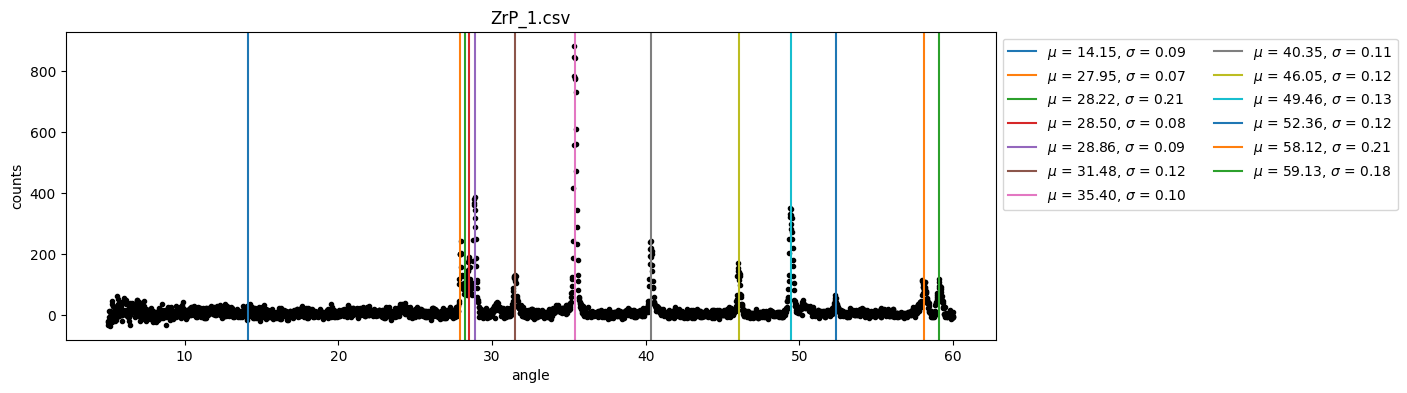

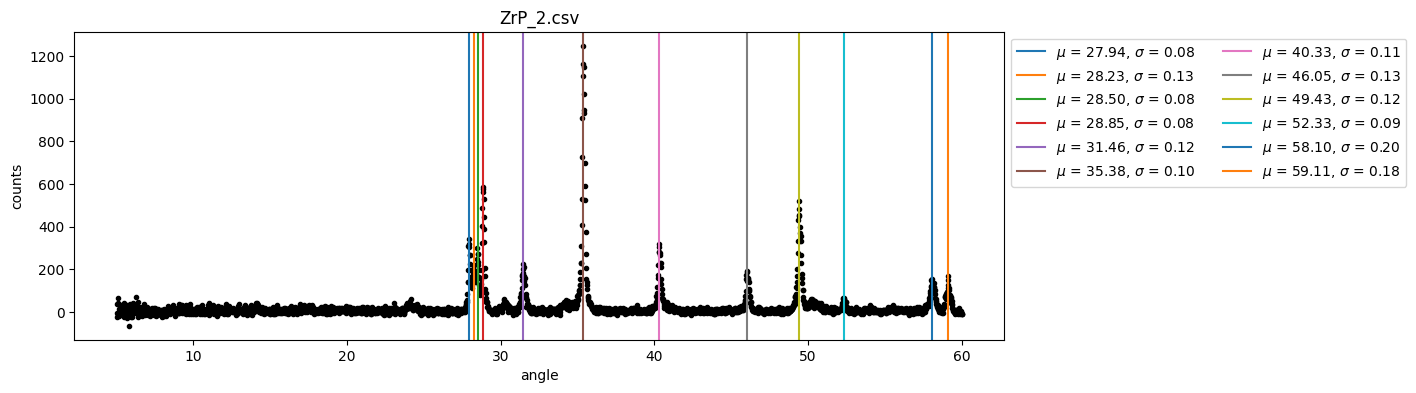

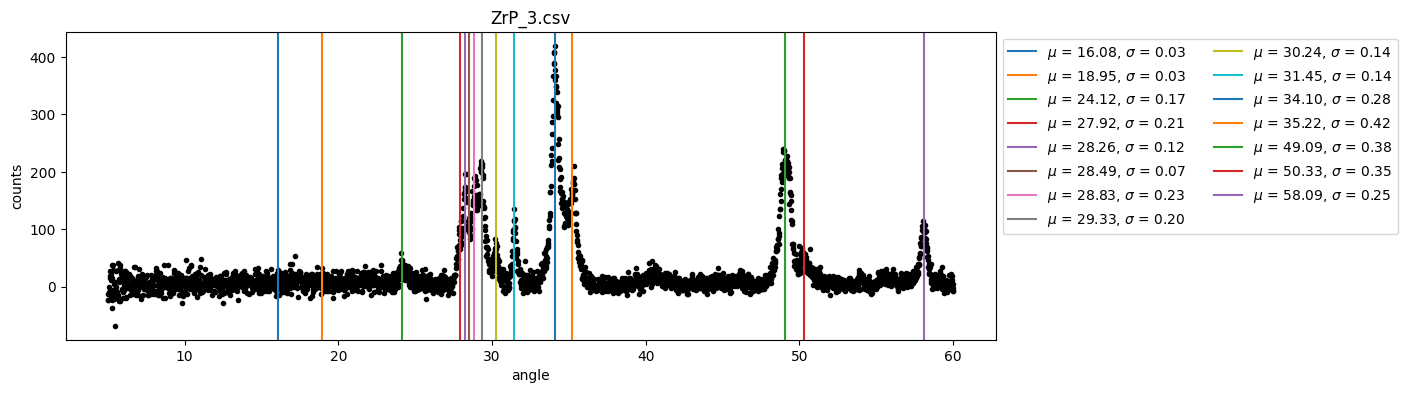

In [19]:
# Plot each of the found datasets with the locations of all of its fitted peaks
for i_dataset, dataset in enumerate(zrp_datasets):
    # Get the raw datapoints for the dataset
    datapoints = (
        session.query(DataPoint).join(DataSet).filter(DataSet.ID == dataset.ID).all()
    )
    # Get all of the fitted peaks in the dataset
    peaks = (
        session.query(FittedPeak.fitted_center, FittedPeak.fitted_sigma)
        .join(DataSegment)
        .join(DataSet)
        .filter(DataSet.ID == dataset.ID)
        .all()
    )
    plot_dataset_with_fitted_peaks(dataset, datapoints, peaks)